In [24]:
from __future__ import print_function
from __future__ import division

import numpy as np
import pandas as pd
import seaborn as sns
#from pylab import *
from IPython.display import Image
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.stats.weightstats as wstats
from collections import OrderedDict

import brewer2mpl
brewer_set2 = brewer2mpl.get_map('Set2', 'qualitative', 8).mpl_colors

%matplotlib inline

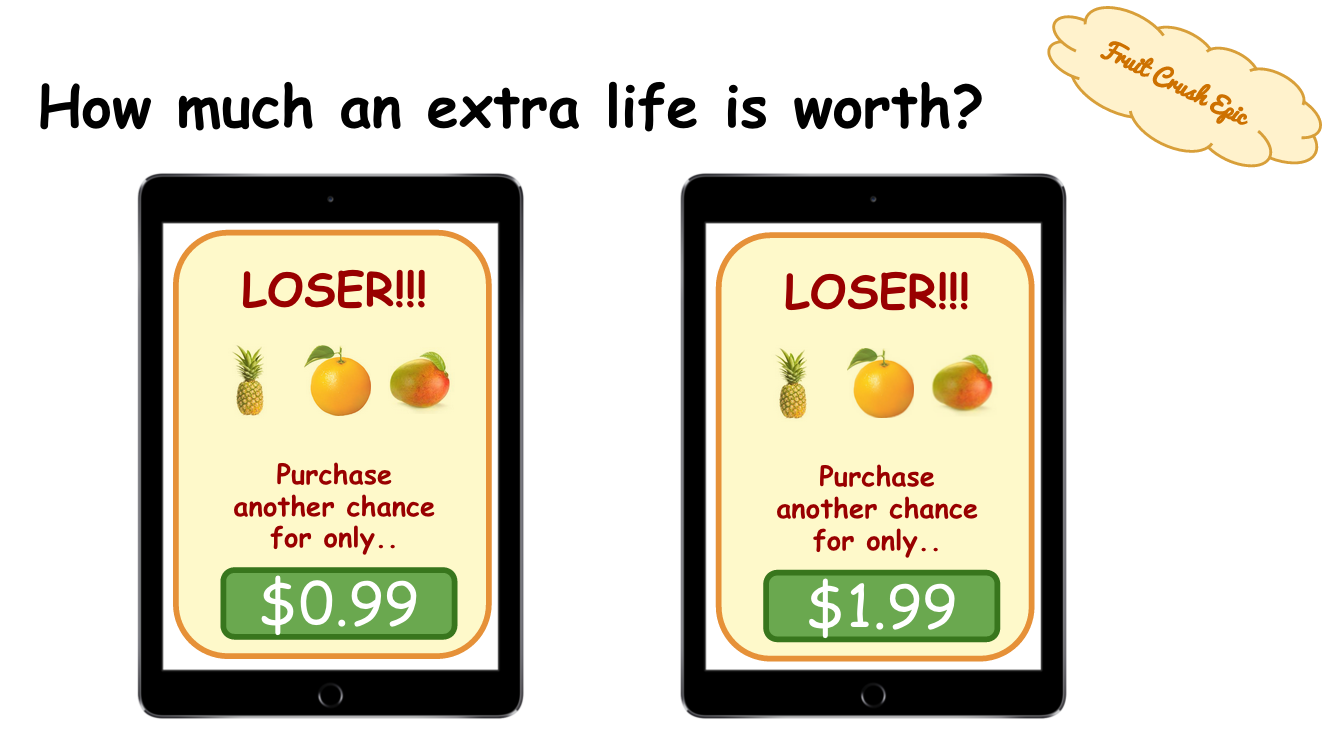

In [25]:
Image('https://cloud.githubusercontent.com/assets/5244286/7023667/ded3b0be-dd2e-11e4-9e6e-2ffede5f122c.png', retina=True)

Currently, we are selling extra life for $1.99. 

Director of Marketing is convinced that game does not convert as many players into payers as competitors and wants to lower the price for extra life.

#### Consider
* There are multiple items to buy in game (lives, boosters, blenders, etc)
* We expect more people to make a $0.99 purchase, so we hope to make more money overall, even at lower price

#### A/B test Design
* We will show A/B test to new users only
* Will run for 2 months
* We will measure overall revenue per user in the first 30 days
* Null-hypothesis: we make more money from $0.99 group

#### Measurements
* Difference in Average Revenue Per User (ARPU) in 30 days
* Difference in Conversion Rate (%% of users who make at least 1 purchase)


In [26]:
# Let's generate some fake data
conversion_a = 0.015 # higher conversion rate in group A
conversion_b = 0.013 # higher conversion rate in group B
installs_a = 30000 # cohort sizes are equal, for simplicity
installs_b = 30000
payers_a = int(installs_a * conversion_a)
payers_b = int(installs_b * conversion_b)
print('payers A', payers_a)
print('payers B', payers_b)

payers A 450
payers B 390


In [27]:
# Check that the difference in Conversion Rates is statistically significant for Alpha=0.05

from statsmodels.stats.proportion import proportions_ztest
count = np.array([payers_a,payers_b])
nobs = np.array([installs_a, installs_b])
z,p = proportions_ztest(count, nobs, value=0, alternative='two-sided')
print(' z-stat = {z} \n p-value = {p}'.format(z=z,p=p))

 z-stat = 2.0848420114464243 
 p-value = 0.03708364384057536


p-value is less than 0.05. Therefore, we have improved conversion rate (% of users who have paid in the first 30 days) significantly.

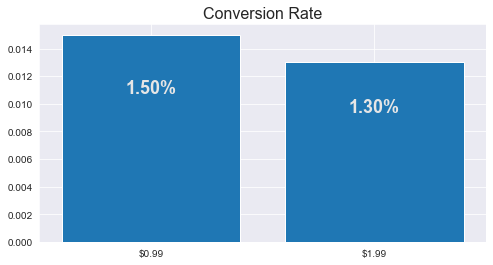

In [28]:
import seaborn as sns
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(8,4))

x = [0,1]
y = [payers_a/installs_a, payers_b/installs_b]
ax.bar(x, y, align='center', width=.8)
ax.set_xticks(x)
ax.set_xticklabels(['$0.99', '$1.99'])
plt.xlim(-.5,1.5)

# value labels
for xx, yy in zip(x,y):
    ax.text(xx, yy*.7, '%0.2f%%'%(100*yy),ha='center', va='bottom', fontdict={'size':18,'weight':'bold','color':(0.9,.9,.9)})
#ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos=0: '%0.0f%%'%(100.0*x)))
plt.title('Conversion Rate', fontdict={'size':16})
pass
# fig.savefig('04.01 conversion rate.png', bbox_inches='tight', pad_inches=0.2 ,dpi=200)


In [29]:
# Let's generate some random payment data. Those distributions are taken from a thin air, just so that we have 
# a very skewed distribution. I don't care whether those numbers look realistic for a mobile casual game, as long as I can 
# show the point. 
np.random.seed(8) # fix seed for reproducability

# Clip (limit) the values in an array.
revenues_a = np.clip(np.random.gamma(.7, 10, payers_a).astype(np.int32),1,1000)*np.clip(np.random.gamma(1, 25, payers_a).round(2), .99, 99)
revenues_b = np.clip(np.random.gamma(.7, 13, payers_b).astype(np.int32),1,1000)*np.clip(np.random.gamma(1, 30, payers_b).round(2), 2.99, 99)

print('A: ARPU={}, min={}, max={}'.format(revenues_a.mean(), revenues_a.min(), revenues_a.max()) )
print('B: ARPU={}, min={}, max={}'.format(revenues_b.mean(), revenues_b.min(), revenues_b.max()) )

pd.set_option('display.precision', 2)
pd.DataFrame(data=revenues_a, columns=['0.99']).describe().join(pd.DataFrame(data=revenues_b, columns=['1.99']).describe())

A: ARPU=151.86206666666666, min=0.99, max=3960.0
B: ARPU=214.2176923076923, min=2.99, max=3647.7999999999997


,0.99,1.99
count,450.00,390.00
mean,151.86,214.22
std,325.31,372.41
min,0.99,2.99
25%,20.82,26.52
50%,55.31,69.44
75%,147.27,231.28
max,3960.00,3647.80


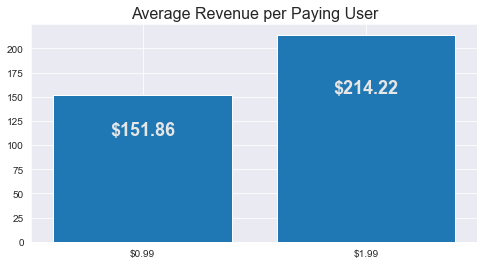

In [30]:
x = [0,1]
y = [revenues_a.mean(), revenues_b.mean()]
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(x, y, align='center', width=.8)
ax.set_xticks(x)
ax.set_xticklabels(['$0.99', '$1.99'])
plt.xlim(-.5,1.5)

for xx, yy in zip(x,y):
    ax.text(xx, yy*.7, '$%0.2f'%(yy),ha='center', va='bottom', fontdict={'size':18,'weight':'bold','color':(0.9,.9,.9)})
#ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos=0: '$%0.02f'%(x)))
plt.title('Average Revenue per Paying User', fontdict={'size':16})
# fig.savefig('04.02 ARPPU.png', bbox_inches='tight', pad_inches=0.2 ,dpi=200)
pass

A: ARPU=2.2779309999999997, min=0.0, max=3960.0
B: ARPU=2.78483, min=0.0, max=3647.7999999999997
ARPU Difference:  0.5068990000000002
ARPU Uplift:  0.22252605544241694


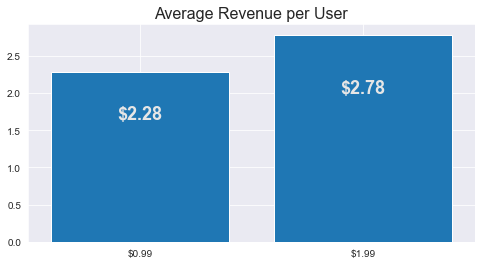

In [31]:
# lets add all non-paying users to our dataset.
revenues_a = np.concatenate([np.zeros(installs_a-payers_a), revenues_a])
revenues_b = np.concatenate([np.zeros(installs_b-payers_b), revenues_b])

print('A: ARPU={}, min={}, max={}'.format(revenues_a.mean(), revenues_a.min(), revenues_a.max()) )
print('B: ARPU={}, min={}, max={}'.format(revenues_b.mean(), revenues_b.min(), revenues_b.max()) )

print('ARPU Difference: ', revenues_b.mean() - revenues_a.mean())
print('ARPU Uplift: ', (revenues_b.mean() - revenues_a.mean())/revenues_a.mean() )

# -------- plot things -------

fig, ax = plt.subplots(figsize=(8,4))

x = [0,1]
y = [revenues_a.mean(), revenues_b.mean()]
ax.bar(x, y, align='center', width=.8)
ax.set_xticks(x)
ax.set_xticklabels(['$0.99', '$1.99'])
plt.xlim(-.5,1.5)

for xx, yy in zip(x,y):
    ax.text(xx, yy*.7, '$%0.2f'%(yy),ha='center', va='bottom', fontdict={'size':18,'weight':'bold','color':(0.9,.9,.9)})
#ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos=0: '$%0.02f'%(x)))
plt.title('Average Revenue per User', fontdict={'size':16})
# fig.savefig('04.02 ARPU.png', bbox_inches='tight', pad_inches=0.2 ,dpi=200)

pass

$ \mu_1 - \mu2 = 0.5069 $
The difference between two cohorts is very substantial. But can we detect statistical significance?

### Method-1: Classical t-test

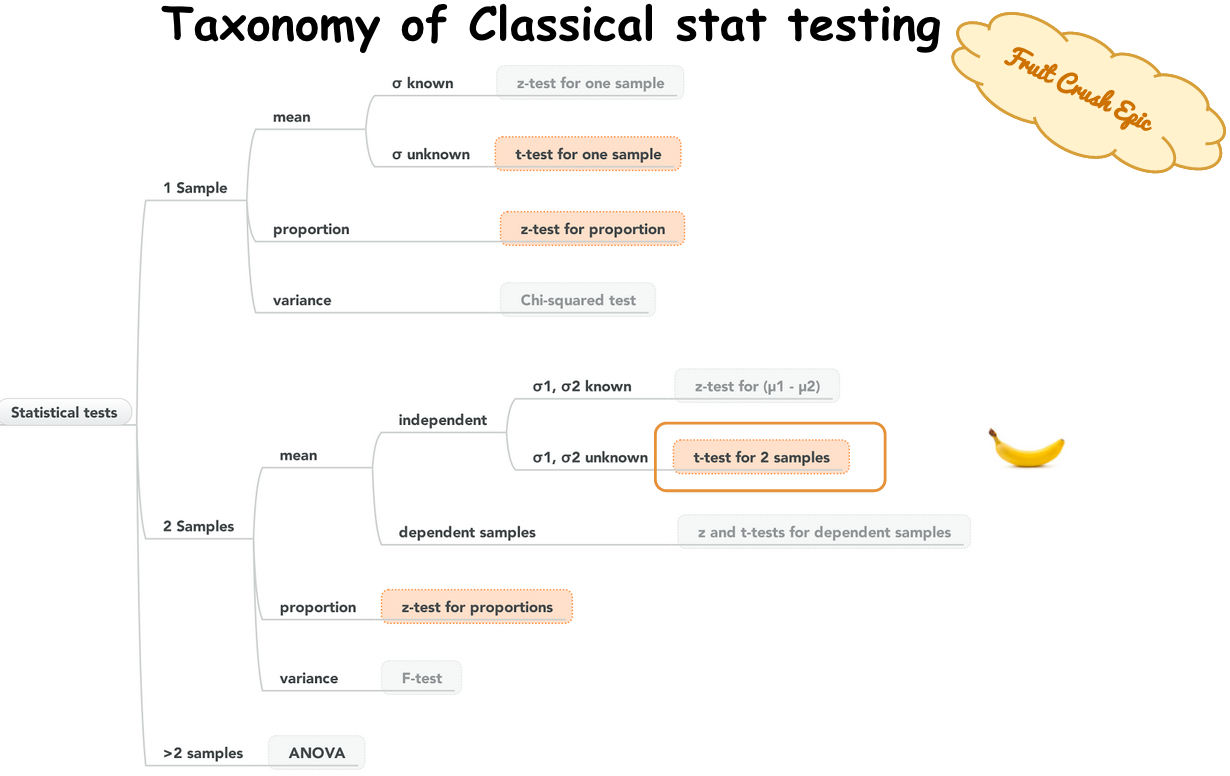

In [32]:
Image('https://cloud.githubusercontent.com/assets/5244286/7023836/39194d94-dd30-11e4-9b54-de15f2743142.png', retina=True)

### Welch's t-test

### $t = \frac{\overline{x_1} - \overline{x_2}}{\sqrt{\frac{S_1^2}{n_1} + \frac{S_2^2}{n_2}}} $

### $CI = (\overline{x_1} - \overline{x_2} ) ± t_{critical} \cdot \sqrt{\frac{S_1^2}{n_1} + \frac{S_2^2}{n_2}} $

In [33]:
import scipy.stats as stats
t, p = stats.ttest_ind(revenues_a, revenues_b, axis=0, equal_var=False)
print(' t-stat = {t} \n p-value = {p}'.format(t=t,p=p/2))

 t-stat = -1.337055975602803 
 p-value = 0.09060474681783709


We failed to reject Null-hypothesis, based on $\alpha=0.05$
Does that mean that we users in $1.99 group paid more due to pure randomness, and we should roll lower price point for everyone?

### Method-2. Split 5 technique

In [34]:
np.random.seed(1)
revenues_b_s = np.array(revenues_b)
revenues_b_s.shape

(30000,)

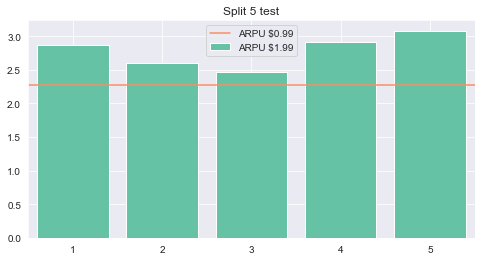

In [35]:
np.random.shuffle(revenues_b_s )
fig, ax = plt.subplots(figsize=(8,4))
revenues_b_s = revenues_b_s.reshape((5,6000))
plt.bar(range(1,6), [revenues_b_s[i].mean() for i in range(5)],
    color=brewer_set2[0], align='center', width=.8, label='ARPU $1.99' )
plt.plot([-2, 6], [revenues_a.mean(), revenues_a.mean()], 
     color=brewer_set2[1], label='ARPU $0.99')
plt.xlim(0.5, 5.5)
plt.title('Split 5 test')
plt.legend();

Let's assume we know nothing about the distribution of Revenues per User. Null-hypothesis is that ARPU is the same between groups. Therefore, it could be higher or lower than average in control group with 50% chance.

But in this case, all observations appear on the same side! The probability of this happenning under Null is 0.5**5 = 3%

#### However, this technique is designed to be abused! Just change the seed and you have different scenario.

### Method-3. Brute-force sampling

We observed the difference between ARPU = $0.507

We can simulate the Null-hypothesis, to see how likely it is to get the difference as extreme as that, assuming that there is no difference between two groups.

In [36]:
%%time
combined_revenues = np.concatenate([revenues_a, revenues_b])
combined_cohort_size = combined_revenues.shape[0]
print('combined_cohort_size ', int(combined_cohort_size*0.5))
sim_size = 10000
sim_diff = np.zeros(sim_size)

np.random.seed(2)
for s in range(sim_size):
    np.random.shuffle(combined_revenues)
    sim_diff[s] = combined_revenues[:int(combined_cohort_size*0.5)].mean() - combined_revenues[int(combined_cohort_size*0.5):].mean()

combined_cohort_size  30000
Wall time: 10.2 s


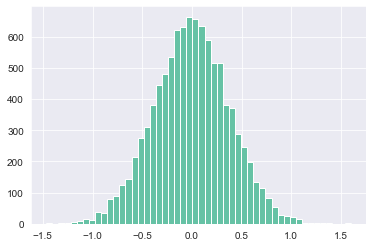

In [37]:
plt.hist(sim_diff, bins=50, color=brewer_set2[0]);

In [38]:
(sim_diff>0.506899).sum()/sim_diff.shape[0]

0.0883

The probability of obtaining the difference as extreme as observed is 8.8%. This is very close to 9%, produced by Welch's t-test.

### Method-4. Clamp the long-tail

The reason for a low sensitivity of any method is, to a large degree, due to players who paid a lot of money.

Those players are knows as "Whales" or VIPs in the industry.
In our same, we have 24 fake players who have spent more than $1000 during the observation period.

If we believe that our pricing options does not have a detrimental affect on probability to spend more than $1000, we can, at the very least, try to quantify the difference for everyone else.

In [39]:
revenues_a_trimmed = np.minimum(revenues_a, 1000)
revenues_b_trimmed = np.minimum(revenues_b, 1000)

print('A: ARPU={}'.format(revenues_a_trimmed.mean()) )
print('B: ARPU={}'.format(revenues_b_trimmed.mean() ))
print('ARPU Difference: ', revenues_b_trimmed.mean()
      - revenues_a_trimmed.mean())

A: ARPU=2.0011756666666667
B: ARPU=2.4898616666666666
ARPU Difference:  0.48868599999999995


In [40]:
t, p = stats.ttest_ind(revenues_a_trimmed, revenues_b_trimmed, axis=0, equal_var=False)
print(' t-stat = {t} \n p-value = {p}'.format(t=t,p=p/2))

 t-stat = -1.7854914296667377 
 p-value = 0.03709347599105856


We can reject the Null-hypothesis, at $\alpha=0.05$
We do not know, however, how the difference in pricing affect the long-tail. But in real business cases it does not matter. Moreover, 95% confidence interval is too prohibitive for lot's of day-to-day managerial decisions.

Good business is about taking good risks.

#### Same, but using brute-force sampling

In [41]:
%%time
combined_revenues = np.concatenate([revenues_a_trimmed, revenues_b_trimmed])
combined_cohort_size = combined_revenues.shape[0]
sim_size = 10000
diff2 = np.zeros(sim_size)

np.random.seed(1)
for s in range(sim_size):
    np.random.shuffle(combined_revenues)
    diff2[s] = combined_revenues[:int(combined_cohort_size*0.5)].mean() - combined_revenues[int(combined_cohort_size*0.5):].mean()

Wall time: 10.3 s


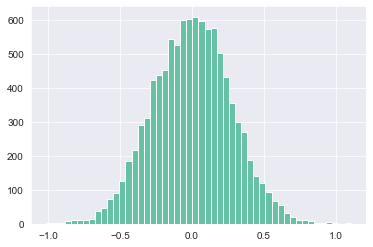

In [42]:
plt.hist(diff2, bins=50, color=brewer_set2[0]);

In [43]:
print((diff2>0.488686).sum(), diff2.shape[0])
(diff2>0.488686).sum()/diff2.shape[0]

369 10000


0.0369

Very similar p-value. 

#### Our recommendation:
Keep $1.99 price point as default and launch another A/B test with more aggressive pricing.